# Aug 8-9, 2023: trials on fitting SINDy on fMRI data 

In [1]:
# from IPython.display import HTML

# HTML('''<script>
# code_show=true; 
# function code_toggle() {
#  if (code_show){
#  $('div.input').hide();
#  } else {
#  $('div.input').show();
#  }
#  code_show = !code_show
# } 
# $( document ).ready(code_toggle);
# </script>
# <form action="javascript:code_toggle()"><input type="submit" value="Click here to toggle on/off the raw code."></form>''')

In [2]:
#HIDE
import csv
import os
import pickle
import random
import sys
from os.path import join as pjoin
import numpy as np
import scipy as sp 
import pandas as pd
import pysindy as ps
import sklearn as skl
import sympy
from scipy.spatial.distance import pdist, cdist, squareform, cosine
from scipy import stats, integrate
import tvb
import networkx as nx
import copy
import matlab.engine
from itertools import product
from tqdm import tqdm

# main dirs
proj_dir = pjoin(os.environ['HOME'], 'network_estimation')

# plotting
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
from mpl_toolkits.mplot3d import Axes3D
from matplotlib.cm import rainbow

plt.rcParamsDefault['font.family'] = "sans-serif"
plt.rcParamsDefault['font.sans-serif'] = "Arial"
plt.rcParams['font.size'] = 14
plt.rcParams["errorbar.capsize"] = 0.5

import cmasher as cmr  # CITE ITS PAPER IN YOUR MANUSCRIPT

# ignore user warnings
import warnings
warnings.filterwarnings("ignore", category=UserWarning)

# folders
sys.path.insert(0, proj_dir)

integrator_keywords = {}
integrator_keywords['rtol'] = 1e-12
integrator_keywords['method'] = 'LSODA'
integrator_keywords['atol'] = 1e-12

In [3]:
class ARGS(): pass
args = ARGS()

args.SEED = 100
np.random.seed(args.SEED)

## dataset

In [4]:
emoprox_dir = pjoin(os.environ['HOME'], 'emoprox_inventory_govinda/emoprox_extract_timeseries')

# ROI atlas/parcellation
atlas_df = pd.read_csv(f"{emoprox_dir}/masks/README_MAX_ROIs_final_gm_85.txt", delimiter='\t')
# display(atlas_df)

roi = 'dorsal Insula'
roi_idx = np.where(atlas_df['Hemi'].str.contains('R') * atlas_df['ROI'].str.contains(roi))[0]
display(atlas_df.iloc[roi_idx])

# data
data_df = pd.read_pickle(f"{emoprox_dir}/dataframes/MAX_ROIs.pkl")

data_df['proximity'] = data_df['proximity'].apply(lambda prox: sp.stats.zscore(prox))


,Hemi,ROI,Index,Voxels,File_Name
49,R,ant. dorsal Insula,50,235,Hammers-gm-0.5-2mm-AntDorsal-INS-r.nii.gz


In [5]:
rids = []
blocks = []
times = []
tss = []
proxs = []
for rid, block in list(product(data_df['rid'].unique(), data_df['block'].unique())):
    # print(rid, block)
    rids.append(rid)
    blocks.append(block)
    df_ = data_df[data_df['rid'] == rid][data_df['block'] == block]
    lmin = np.min(df_['timeseries'].apply(lambda x: x.shape[0]).values)
    times.append(df_['time'].iloc[0][:lmin])
    tss.append(df_['timeseries'].apply(lambda x: x[:lmin, ...]).mean())
    proxs.append(df_['proximity'].apply(lambda x: x[:lmin, ...]).mean())

df = pd.DataFrame(
    data={
        'rid': rids,
        'block': blocks,
        'time': times,
        'timeseries': tss,
        'proximity': proxs,
        },
)
df

,rid,block,time,timeseries,proximity
0,0,1,"[0.0, 1.25, 2.5, 3.75, 5.0, 6.25, 7.5, 8.75, 1...","[[-0.02390497788475301, -0.04270538325639377, ...","[-1.2079791745344644, -0.9047940812561361, -0...."
1,0,2,"[212.5, 213.75, 215.0, 216.25, 217.5, 218.75, ...","[[-0.16295314653691623, -0.01666933747741346, ...","[0.017511788254418383, 0.2679718311407305, 0.6..."
2,1,1,"[0.0, 1.25, 2.5, 3.75, 5.0, 6.25, 7.5, 8.75, 1...","[[-0.198032265266743, -0.13559650586994343, -0...","[0.13131557794480705, -0.08549816680325, -0.30..."
3,1,2,"[211.25, 212.5, 213.75, 215.0, 216.25, 217.5, ...","[[0.15476719317870366, 0.16892929443746676, 0....","[-0.3047569397545775, -0.08603546353546888, 0...."
4,2,1,"[0.0, 1.25, 2.5, 3.75, 5.0, 6.25, 7.5, 8.75, 1...","[[-0.1134854874655991, -0.13134632084245404, -...","[-0.04327633268643199, -0.3035262893146636, -0..."
5,2,2,"[213.75, 215.0, 216.25, 217.5, 218.75, 220.0, ...","[[-0.25074962623687325, -0.02089252445433281, ...","[-0.4111067901733918, -0.5915982171252103, -0...."
6,3,1,"[0.0, 1.25, 2.5, 3.75, 5.0, 6.25, 7.5, 8.75, 1...","[[-0.06581703739227845, -0.15415326977058338, ...","[-0.513334016610507, -0.282239826108365, -0.05..."
7,3,2,"[213.75, 215.0, 216.25, 217.5, 218.75, 220.0, ...","[[-0.3144177276600097, 0.06739999981492178, -0...","[-0.8029868682572703, -0.5041406737913097, -0...."
8,4,1,"[0.0, 1.25, 2.5, 3.75, 5.0, 6.25, 7.5, 8.75, 1...","[[-0.2435785864687706, -0.28628994882598463, -...","[0.240098562306032, -0.021445949927976136, -0...."
9,4,2,"[213.75, 215.0, 216.25, 217.5, 218.75, 220.0, ...","[[-0.4302520248277172, -0.18604681879257243, 0...","[0.13384122043478605, -0.05342583016181571, -0..."


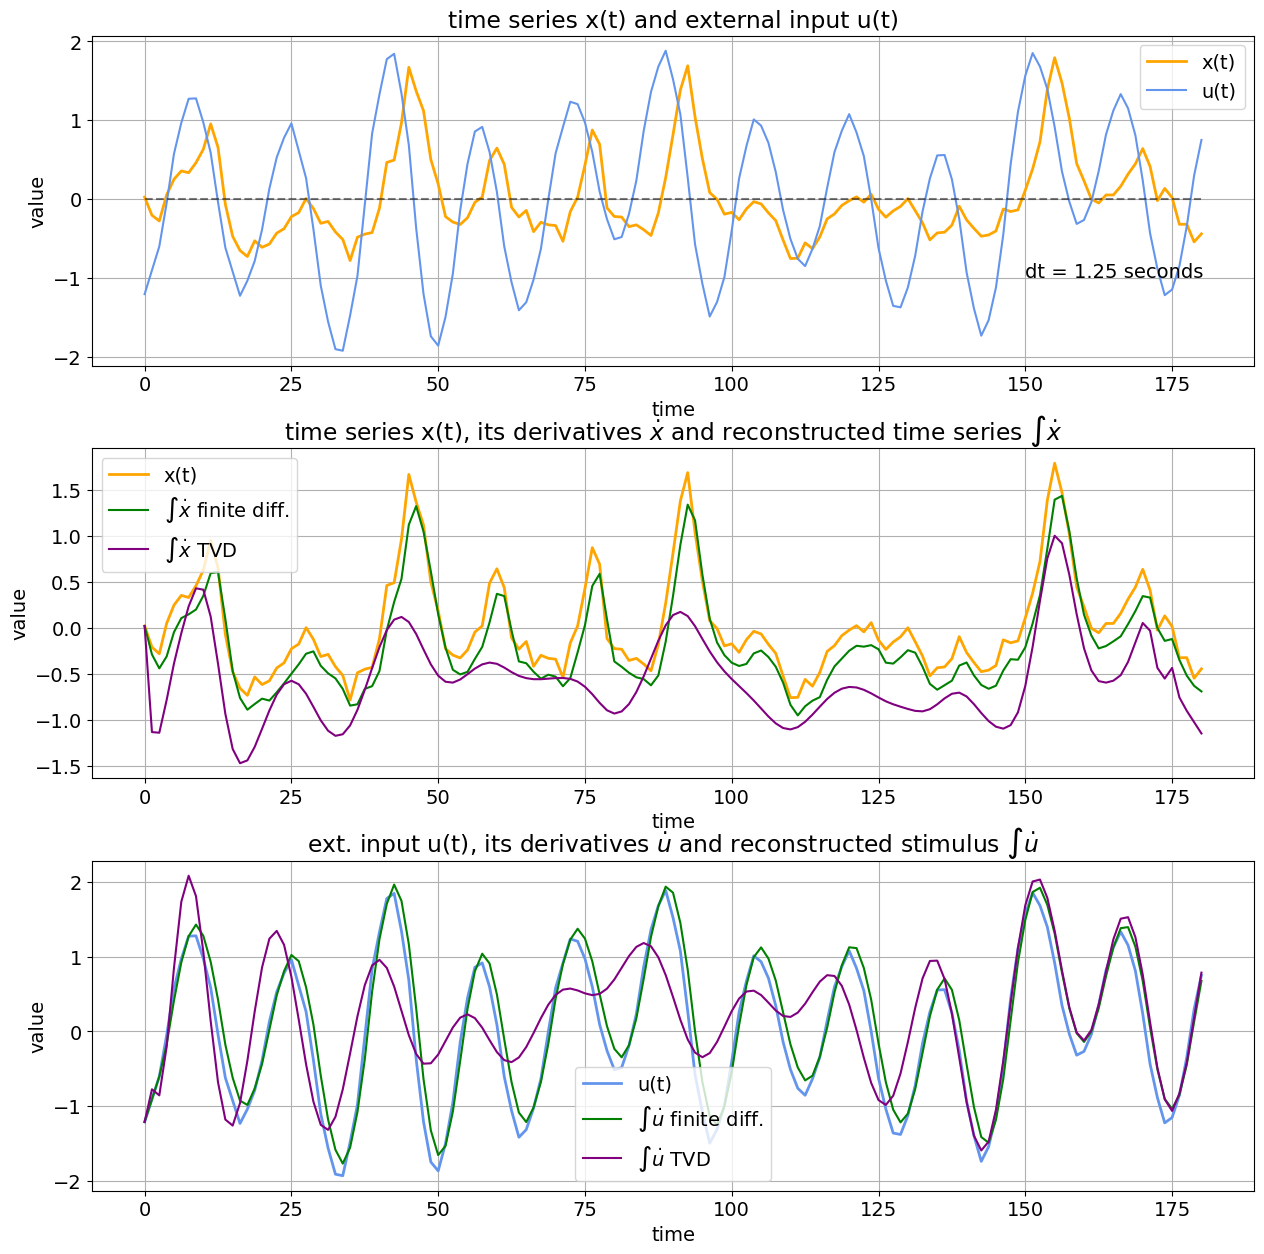

In [6]:
x = df.iloc[0]['timeseries'][:, roi_idx]
time = df.iloc[0]['time']
dt = time[1]-time[0]

# derivatives $\dot{x}$
# diff = ps.SINDyDerivative(kind="trend_filtered", order=0, alpha=1e-2)
xdiff = ps.SmoothedFiniteDifference()._differentiate(x, time)
x_ = np.concatenate([x[0], x[0] + np.cumsum(xdiff)[:-1]*dt])
prox = df.iloc[0]['proximity'][:, None]

# basic plot check
plot_kws = dict(linewidth=2)
fig, axs = plt.subplots(nrows=3, ncols=1, figsize=(15, 15))
plt.subplots_adjust(
    left=None, bottom=None, 
    right=None, top=None, 
    wspace=None, hspace=0.25
)

ax = axs[0]
ax.plot(time, x, c='orange', linestyle='-', label='x(t)', **plot_kws)
ax.plot(time, prox, c='cornflowerblue', linestyle='-', label='u(t)')
ax.plot(time, 0*time, c='black', linestyle='--', alpha=0.5)
ax.text(150, -1, 'dt = 1.25 seconds')
ax.grid(True)
ax.set(xlabel='time', ylabel='value')#, ylim=[-1.5, 1.5])
ax.set_title('time series x(t) and external input u(t)')
ax.legend()

ax = axs[1]
ax.plot(time, x, c='orange', linestyle='-', label='x(t)', **plot_kws)
xdiff = ps.FiniteDifference()._differentiate(x, time)
x_ = np.concatenate([x[0], x[0] + np.cumsum(xdiff)[:-1]*dt])
ax.plot(time, x_, c='green', linestyle='-', label='$\int{\dot{x}}$ finite diff.')
xdiff = ps.SINDyDerivative(kind="trend_filtered", order=0, alpha=1e-2)._differentiate(x, time)
x_ = np.concatenate([x[0], x[0] + np.cumsum(xdiff)[:-1]*dt])
ax.plot(time, x_, c='purple', linestyle='-', label='$\int{\dot{x}}$ TVD')
ax.grid(True)
ax.set(xlabel='time', ylabel='value')#, ylim=[-1.5, 1.5])
ax.set_title('time series x(t), its derivatives $\dot{x}$ and reconstructed time series $\int{\dot{x}}$')
ax.legend()

ax = axs[2]
ax.plot(time, prox, c='cornflowerblue', linestyle='-', label='u(t)', **plot_kws)
udiff = ps.FiniteDifference()._differentiate(prox, time)
u_ = np.concatenate([prox[0], prox[0] + np.cumsum(udiff)[:-1]*dt])
ax.plot(time, u_, c='green', linestyle='-', label='$\int{\dot{u}}$ finite diff.')
udiff = ps.SINDyDerivative(kind="trend_filtered", order=0, alpha=1e-2)._differentiate(prox, time)
u_ = np.concatenate([prox[0], prox[0] + np.cumsum(udiff)[:-1]*dt])
ax.plot(time, u_, c='purple', linestyle='-', label='$\int{\dot{u}}$ TVD')
ax.grid(True)
ax.set(xlabel='time', ylabel='value')#, ylim=[-1.5, 1.5])
ax.set_title('ext. input u(t), its derivatives $\dot{u}$ and reconstructed stimulus $\int{\dot{u}}$')
ax.legend()

## SINDy on fMRI signal

$$ \dot{x} = f(x, u) $$

### dorsal anterior insula

In [7]:
def discover_eqs(args, t_train, x_train, u_train, t_test, x_test, u_test, kwargs):
    model = ps.SINDy(
        optimizer=ps.STLSQ(threshold=kwargs['threshold']),
        feature_library=ps.PolynomialLibrary(degree=kwargs['poly_order'], include_bias=args.include_bias),
        differentiation_method=ps.FiniteDifference(),
        feature_names=['x'] + [f'u{i}' for i in range(args.num_delays)],
        discrete_time=args.discrete_time,
    )
    model.fit(
        x=x_train, 
        t=t_train, 
        u=u_train, 
        multiple_trajectories=args.multiple_trajs,
        library_ensemble=args.lib_ensemble,
    )
    model.print()

    # simulate
    if ~args.discrete_time:
        x_sim = model.simulate(
            x0=x_test[0],
            t=t_test,
            u=u_test,
        )
        x_dot = model.predict(
            x=x_test, 
            u=u_test, 
            multiple_trajectories=False
        )
    elif args.discrete_time:
        x_sim = model.simulate(
            x0=x_test[0],
            t=len(t_test),
            u=u_test,
        )
        x_dot = model.predict(
            x=x_test, 
            u=u_test, 
            multiple_trajectories=False
        )

    # predicted vs empirical time series: 
    # 1.0 (perfect predictions) or 0.0 (imperfect predictions)
    r2 = skl.metrics.r2_score(x_test, x_sim)
    c = np.corrcoef(np.hstack([x_test, x_sim]).T)[0, 1]
    print(f"Rsquared: {r2}")
    print(f"correlation: {c}")

    return x_sim, x_dot

def get_u(args, u):
    u_ = np.zeros((u.shape[0], args.num_delays))
    for i in range(args.num_delays):
        u_[:, i] = np.roll(u, i)
    return u_

# -----------
args.time = df.iloc[0]['time']
args.dt = args.time[1] - args.time[0]
args.num_delays = 1

args.multiple_trajs = True
args.lib_ensemble = True
args.include_bias = True
args.discrete_time = False

t_train = [None for _ in df.index]
x_train = copy.deepcopy(t_train)
u_train = copy.deepcopy(t_train)
for idx, row in df.iterrows():
    t_train[idx] = df.iloc[idx]['time']
    x_train[idx] = df.iloc[idx]['timeseries'][:, roi_idx]
    u_train[idx] = get_u(args, df.iloc[idx]['proximity'])

t_test = df.iloc[0]['time']
x_test = df.iloc[0]['timeseries'][:, roi_idx]
u_test = get_u(args, df.iloc[0]['proximity'])

kwargs = {'threshold':0.01, 'poly_order':3, 'n_freqs':1}
x_sim, x_dot = discover_eqs(
    args, 
    t_train, x_train, u_train, 
    t_test, x_test, u_test, 
    kwargs,
)
x_dif = ps.FiniteDifference()._differentiate(x_test, t_test)

(x)' = -0.017 1 + -0.133 x + 0.091 u0 + -0.129 x^2 + 0.124 x u0 + 0.016 u0^2 + 0.036 x^3 + 0.052 x^2 u0 + 0.049 x u0^2 + -0.012 u0^3


Rsquared: 0.46455553228347046
correlation: 0.7170161686044753


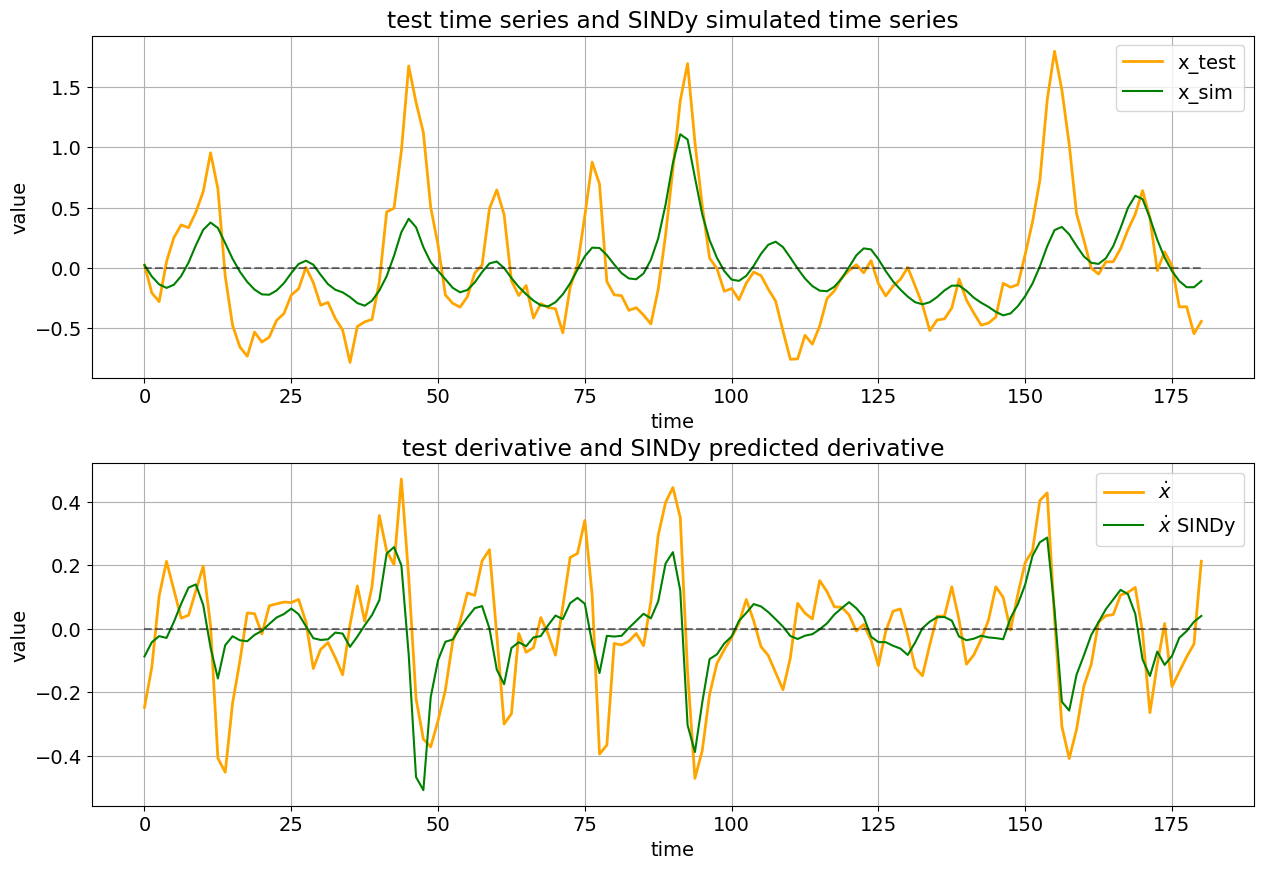

In [8]:
# plot check
plot_kws = dict(linewidth=2)
fig, axs = plt.subplots(nrows=2, ncols=1, figsize=(15, 10))
plt.subplots_adjust(
    left=None, bottom=None, 
    right=None, top=None, 
    wspace=None, hspace=0.25
)

ax = axs[0]
ax.plot(t_test, x_test, c='orange', linestyle='-', label='x_test', **plot_kws)
ax.plot(t_test, x_sim, c='green', linestyle='-', label='x_sim')
ax.plot(t_test, 0*t_test, c='black', linestyle='--', alpha=0.5)
ax.grid(True)
ax.set(xlabel='time', ylabel='value')#, ylim=[-1.5, 1.5])
ax.set_title('test time series and SINDy simulated time series')
ax.legend()

ax = axs[1]
ax.plot(t_test, x_dif, c='orange', linestyle='-', label='$\dot{x}$', **plot_kws)
ax.plot(t_test, x_dot, c='green', linestyle='-', label='$\dot{x}$ SINDy')
ax.plot(t_test, 0*t_test, c='black', linestyle='--', alpha=0.5)
ax.grid(True)
ax.set(xlabel='time', ylabel='value')#, ylim=[-1.5, 1.5])
ax.set_title('test derivative and SINDy predicted derivative')
ax.legend()

### all rois

In [9]:
def discover_eqs(args, t_train, x_train, u_train, t_test, x_test, u_test, kwargs):
    model = ps.SINDy(
        optimizer=ps.STLSQ(threshold=kwargs['threshold']),
        feature_library=ps.PolynomialLibrary(degree=kwargs['poly_order'], include_bias=args.include_bias, include_interaction=False),
        differentiation_method=ps.FiniteDifference(),
        feature_names=['x0', 'x1'] + [f'u{i}' for i in range(args.num_delays)],
        discrete_time=args.discrete_time,
    )
    model.fit(
        x=x_train, 
        t=t_train, 
        u=u_train, 
        multiple_trajectories=args.multiple_trajs,
        library_ensemble=args.lib_ensemble,
    )
    model.print()

    # simulate
    if ~args.discrete_time:
        x_sim = model.simulate(
            x0=x_test[0],
            t=t_test,
            u=u_test,
        )
        x_dot = model.predict(
            x=x_test, 
            u=u_test, 
            multiple_trajectories=False
        )
    elif args.discrete_time:
        x_sim = model.simulate(
            x0=x_test[0],
            t=len(t_test),
            u=u_test,
        )
        x_dot = model.predict(
            x=x_test, 
            u=u_test, 
            multiple_trajectories=False
        )

    # predicted vs empirical time series: 
    # 1.0 (perfect predictions) or 0.0 (imperfect predictions)
    r2 = skl.metrics.r2_score(x_test, x_sim)
    c = np.corrcoef(np.hstack([x_test, x_sim]).T)[0, 1]
    print(f"Rsquared: {r2}")
    print(f"correlation: {c}")

    return x_sim, x_dot

def get_u(args, u):
    u_ = np.zeros((u.shape[0], args.num_delays))
    for i in range(args.num_delays):
        u_[:, i] = np.roll(u, i)
    return u_

# -----------
args.time = df.iloc[0]['time']
args.dt = args.time[1] - args.time[0]
args.num_delays = 1

args.multiple_trajs = True
args.lib_ensemble = True
args.include_bias = True
args.discrete_time = False

t_train = [None for _ in df.index]
x_train = copy.deepcopy(t_train)
u_train = copy.deepcopy(t_train)
for idx, row in df.iterrows():
    t_train[idx] = df.iloc[idx]['time']
    x_train[idx] = df.iloc[idx]['timeseries'][:, [0, 1]]
    u_train[idx] = get_u(args, df.iloc[idx]['proximity'])

t_test = df.iloc[0]['time']
x_test = df.iloc[0]['timeseries'][:, [0, 1]]
u_test = get_u(args, df.iloc[0]['proximity'])

kwargs = {'threshold':0.01, 'poly_order':3, 'n_freqs':1}
x_sim, x_dot = discover_eqs(
    args, 
    t_train, x_train, u_train, 
    t_test, x_test, u_test, 
    kwargs,
)
# x_dif = ps.FiniteDifference()._differentiate(x_test, t_test)

(x0)' = -0.017 x0 + -0.050 x0^2 + 0.103 x1^2 + 0.040 x0^3 + 0.176 x1^3
(x1)' = 0.011 1 + -0.012 u0 + -0.028 x0^2 + 0.066 x1^2 + -0.011 u0^2 + -0.131 x0^3 + 0.056 x1^3
Rsquared: 0.04883218871131745
correlation: 0.47223168392163084
